# Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization

The next algorithm we are going to analyze is Grad-CAM. The first four cells are already known from the previous notebook.

In [1]:
import torch
from torchvision import models, transforms
import numpy as np
import medmnist
import matplotlib.cm as cm
from torch.utils.data import DataLoader

import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18()
model.fc = torch.nn.Linear(model.fc.in_features, 7)
model.load_state_dict(torch.load("../Exercise/best_dermamnist_resnet_model.pth", map_location=device))

<All keys matched successfully>

In [3]:
data_flag = 'dermamnist'
info = medmnist.INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

mean = 0.5
std = 0.5
batch_size = 128

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

test_dataset = DataClass(split='test', transform=data_transform, size=64, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

In [4]:
images, _ = next(iter(test_loader))
images = images.to(device)

## **Applying Grad-CAM**

The function get a gradcam heatmap is already provided below:

In [5]:
# This function does NOT need any changes
def make_gradcam_heatmap(model, input_tensor, target_layer, pred_index=None):
    features = []
    gradients = []
    def forward_hook(module, input, output):
        features.append(output)
    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    fwd_handle = target_layer.register_forward_hook(forward_hook)
    bwd_handle = target_layer.register_full_backward_hook(backward_hook)

    model.eval()
    output = model(input_tensor)
    if pred_index is None:
        pred_index = torch.argmax(output)

    model.zero_grad()
    class_score = output[:, pred_index]
    class_score.backward()
    
    feature_map = features[0].detach()
    grads = gradients[0].detach()

    fwd_handle.remove()
    bwd_handle.remove()

    pooled_grads = torch.mean(grads, dim=[0, 2, 3])
    for i in range(feature_map.shape[1]):
        feature_map[:, i, :, :] *= pooled_grads[i]

    heatmap = torch.mean(feature_map, dim=1).squeeze()
    heatmap = F.relu(heatmap)
    heatmap /= torch.max(heatmap)
    return heatmap

We want to overlay the heatmap on the image that we are explaining.

In [8]:
target_layer = model.layer3[-1]

# To Do

# 1. Select one image from images and add batch dimension
# 2. Run the function make_gradcam_heatmap
# 3. Use torch.nn.functionl.interpolate to bring heatmap to image dimensions (64x64)

# -> solution
image_idx_to_explain = 3
image = images[image_idx_to_explain]
img_tensor = image.unsqueeze(0)

heatmap = make_gradcam_heatmap(model, img_tensor, target_layer)
heatmap = heatmap.unsqueeze(0).unsqueeze(0)
resized_heatmap = F.interpolate(
    heatmap,
    size=(img_tensor.shape[2], img_tensor.shape[3]),
    mode="bilinear",
    align_corners=False,
)
heatmap = resized_heatmap.squeeze().cpu().numpy()

Lastly, the plot:

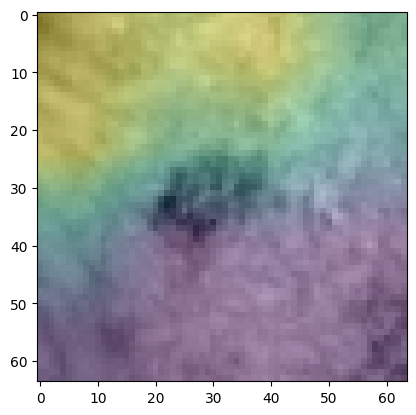

In [9]:
def rgb2gray(rgb):
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray


plt.imshow(rgb2gray(np.transpose(image, (2, 1, 0))), cmap="gray")
plt.imshow(heatmap, alpha=0.4)
plt.show()